# Predição de mortalidade em internações por pneumonias bacterianas sensíveis à Atenção Primária no Brasil, 2017-2021

## Análise Exploratória

### 1. Importando dados

In [184]:
# IMPORTANDO PACOTES 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd  
import chart_studio.plotly as py
import plotly.graph_objs as gp 
import rpy2.robjects as robjects
import seaborn as sns

from scipy.stats import chi2, chi2_contingency, iqr, pearsonr
from sklearn.preprocessing import StandardScaler

In [127]:
#IMPORTANDO DADOS DE INTERNAÇÃO POR PNEUMONIA
colunas =  [ "N_AIH","IDADE","SEXO","UF_ZI","NUM_FILHOS","INSTRU","MORTE","CID_MORTE","DIAS_PERM","DIAG_PRINC","DIAG_SECUN","DT_INTER","ANO_CMPT","MES_CMPT","MARCA_UTI","UTI_MES_TO","INFEHOSP"]

sih_pneumo = pd.read_csv("sih_pneumonia_1721.csv")
sih_pneumo.set_axis(colunas, axis= 1, inplace= True)
sih_pneumo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734183 entries, 0 to 734182
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   N_AIH       734183 non-null  int64  
 1   IDADE       734183 non-null  int64  
 2   SEXO        734183 non-null  int64  
 3   UF_ZI       734183 non-null  int64  
 4   NUM_FILHOS  734183 non-null  int64  
 5   INSTRU      734183 non-null  int64  
 6   MORTE       734183 non-null  int64  
 7   CID_MORTE   734183 non-null  int64  
 8   DIAS_PERM   734183 non-null  int64  
 9   DIAG_PRINC  734183 non-null  object 
 10  DIAG_SECUN  734183 non-null  int64  
 11  DT_INTER    734183 non-null  int64  
 12  ANO_CMPT    734183 non-null  int64  
 13  MES_CMPT    734183 non-null  int64  
 14  MARCA_UTI   734183 non-null  int64  
 15  UTI_MES_TO  734183 non-null  int64  
 16  INFEHOSP    0 non-null       float64
dtypes: float64(1), int64(15), object(1)
memory usage: 95.2+ MB


In [128]:
#CRIANDO DICIONÁRIO DE REGIÃO
regiao = {"1":"Norte", "2":"Nordeste", "3":"Sudeste", "4":"Sul", "5":"Centro-Oeste"}

In [129]:
#IMPORTANDO DADOS DE INTERNAÇÃO POR UF E ANO
internacoes_br = pd.read_csv("A110224189_28_143_208.csv", encoding= "UTF-8", sep = ";")
internacoes_br.rename(columns = {"Unidade da Federa��o":"UF"}, inplace= True)
internacoes_br["UF"] = internacoes_br["UF"].astype('str').str.extractall('(\d+)').unstack()
internacoes_br = internacoes_br[["UF", "2017", "2018", "2019", "2020", "2021", "2022"]]
internacoes_br.drop(["2022"], axis = 1, inplace= True)
internacoes_br["REGIAO"] = internacoes_br["UF"].str.slice(0,1)
internacoes_br["REGIAO"] = internacoes_br["REGIAO"].replace(regiao)
internacoes_br = internacoes_br.drop(27, axis= 0)
internacoes_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   UF      27 non-null     object
 1   2017    27 non-null     int64 
 2   2018    27 non-null     int64 
 3   2019    27 non-null     int64 
 4   2020    27 non-null     int64 
 5   2021    27 non-null     int64 
 6   REGIAO  27 non-null     object
dtypes: int64(5), object(2)
memory usage: 1.6+ KB


### 2. Preparando os dados

In [130]:
#VERIFICANDO DATAS DE INTERNAÇÃO
sih_pneumo['DT_INTER'] = sih_pneumo['DT_INTER'].astype("string")

sih_pneumo['ANO_INT'] = sih_pneumo['DT_INTER'].str.slice(0, 4)
sih_pneumo['ANO_INT'] = sih_pneumo['ANO_INT'].astype(int)
sih_pneumo['ANO_INT'].value_counts().sort_index()

2016      6966
2017    160694
2018    170708
2019    179618
2020     98501
2021     92934
2022     24762
Name: ANO_INT, dtype: int64

In [131]:
#VERIFICANDO ANO DE COMPETENCIA
sih_pneumo['ANO_CMPT'] = sih_pneumo['ANO_CMPT'].astype(int)
sih_pneumo['ANO_CMPT'].value_counts().sort_index()

2017    159417
2018    169893
2019    179769
2020    102449
2021     89492
2022     33163
Name: ANO_CMPT, dtype: int64

In [132]:
#FILTRANDO POR ANO DE INTERNAÇÃO´
anos = [2017, 2018, 2019, 2020, 2021]
sih_pneumo = sih_pneumo[sih_pneumo['ANO_INT'].isin(anos)]
sih_pneumo['ANO_INT'].value_counts().sort_index()

2017    160694
2018    170708
2019    179618
2020     98501
2021     92934
Name: ANO_INT, dtype: int64

#### 2.1 Identificando e classificando os dados

In [133]:
#IDENTIFICANDO OS DADOS
sih_pneumo2 = sih_pneumo.copy()
sih_pneumo2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702455 entries, 0 to 734155
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   N_AIH       702455 non-null  int64  
 1   IDADE       702455 non-null  int64  
 2   SEXO        702455 non-null  int64  
 3   UF_ZI       702455 non-null  int64  
 4   NUM_FILHOS  702455 non-null  int64  
 5   INSTRU      702455 non-null  int64  
 6   MORTE       702455 non-null  int64  
 7   CID_MORTE   702455 non-null  int64  
 8   DIAS_PERM   702455 non-null  int64  
 9   DIAG_PRINC  702455 non-null  object 
 10  DIAG_SECUN  702455 non-null  int64  
 11  DT_INTER    702455 non-null  string 
 12  ANO_CMPT    702455 non-null  int64  
 13  MES_CMPT    702455 non-null  int64  
 14  MARCA_UTI   702455 non-null  int64  
 15  UTI_MES_TO  702455 non-null  int64  
 16  INFEHOSP    0 non-null       float64
 17  ANO_INT     702455 non-null  int64  
dtypes: float64(1), int64(15), object(1), string(

In [134]:
#AJUSTANDO OS DADOS SEGUNDO O TIPO
sih_pneumo2['CID_MORTE'] = sih_pneumo2['CID_MORTE'].astype(str)
sih_pneumo2['DIAG_PRINC'] = sih_pneumo2['DIAG_PRINC'].astype(str)
sih_pneumo2['DIAG_SECUN'] = sih_pneumo2['DIAG_SECUN'].astype(str)
sih_pneumo2['UF_ZI'] = sih_pneumo2['UF_ZI'].astype(str)
sih_pneumo2['UF'] = sih_pneumo2['UF_ZI'].str.slice(0, 2)
sih_pneumo2['IDADE'] = sih_pneumo2['IDADE'].astype("float64")
sih_pneumo2['DT_INTER'] = pd.to_datetime(sih_pneumo2['DT_INTER'])

sih_pneumo2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702455 entries, 0 to 734155
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   N_AIH       702455 non-null  int64         
 1   IDADE       702455 non-null  float64       
 2   SEXO        702455 non-null  int64         
 3   UF_ZI       702455 non-null  object        
 4   NUM_FILHOS  702455 non-null  int64         
 5   INSTRU      702455 non-null  int64         
 6   MORTE       702455 non-null  int64         
 7   CID_MORTE   702455 non-null  object        
 8   DIAS_PERM   702455 non-null  int64         
 9   DIAG_PRINC  702455 non-null  object        
 10  DIAG_SECUN  702455 non-null  object        
 11  DT_INTER    702455 non-null  datetime64[ns]
 12  ANO_CMPT    702455 non-null  int64         
 13  MES_CMPT    702455 non-null  int64         
 14  MARCA_UTI   702455 non-null  int64         
 15  UTI_MES_TO  702455 non-null  int64         
 16  IN

In [135]:
#INCLUINDO NOME DAS CID NA VARIÁVEL DE DIAGNÓSTICO PRINCIPAL
dic_cid = {"J159": "J159 - Pneumonia bacteriana NE", "J158": "J158 - Pneumonia bacteriana NE", "J181": "J181 - Pneumonia lobar NE ",
 "J154": "J154 - Pneumonia por Streptococus", "J153": "J153 - Pneumonia por Streptococus", "J14": "J14 - Pneumonia por Haemophilus infuenzae",
 "J13": "J13 - Pneumonia Pneumocócica"}

sih_pneumo2['DIAG_PRINC'] = sih_pneumo2['DIAG_PRINC'].replace(dic_cid)

In [136]:
#CLASSIFICANDO VALORES DE TIPO DE UTI
uti = {0:"Não usou UTI", 
       51:"UTI adulto - tipo II Covid-19", 
       52:"UTI pediátrica - tipo II Covid-19",
       74:"UTI adulto - tipo I",
       75:"UTI adulto - tipo II",
       76:"UTI adulto - tipo III",
       77:"UTI infantil - tipo I",
       78:"UTI infantil - tipo II",
       79:"UTI infantil - tipo III",
       80:"UTI neonatal - tipo I",
       81:"UTI neonatal - tipo II",
       82:"UTI neonatal - tipo III",
       83:"UTI de queimados",
       85:"UTI coronariana tipo II - UCO tipo II",
       86:"UTI coronariana tipo III - UCO tipo III",
       99:"UTI Doador",
       1: "Utilizou mais de um tipo de UTI"}

sih_pneumo2["MARCA_UTI"] = sih_pneumo2["MARCA_UTI"].replace(uti)

#### 2.2 *Missing values*

In [137]:
#EXCLUINDO VARIÁVEIS COM TODOS OS VALORES NULOS, VAZIOS OU ÚNICOS
sih_pneumo2.drop(['INFEHOSP', 'UF_ZI', 'NUM_FILHOS', 'INSTRU', 'CID_MORTE', 'DIAG_SECUN'], axis= 1, inplace= True)

#### 2.3 *Outliers*

In [138]:
#SELECIONANDO VARIÁVEIS QUE PODEM APRESENTAR OUTLIERS
sih_box = sih_pneumo2[['IDADE', 'DIAS_PERM', 'UTI_MES_TO']]

In [139]:
#TRANSFORMANDO DADOS PARA A MESMA ESCALA
scale = StandardScaler()

sih_box2 = pd.DataFrame(scale.fit_transform(sih_box))
sih_box2.set_axis(['IDADE', 'DIAS_PERM', 'UTI_MES_TO'], axis=1, inplace=True)
sih_box2 = pd.DataFrame(sih_box2.stack()).reset_index()
sih_box2.drop('level_0', axis = 1, inplace = True)
sih_box2.rename(columns = {'level_1':'variables', 0:'standard_value'}, inplace = True)

[Text(0.5, 0, 'Valores padronizados'),
 Text(0, 0.5, 'Variáveis'),
 Text(0.5, 1.0, 'Boxplot dias de permanência e idade padronizados')]

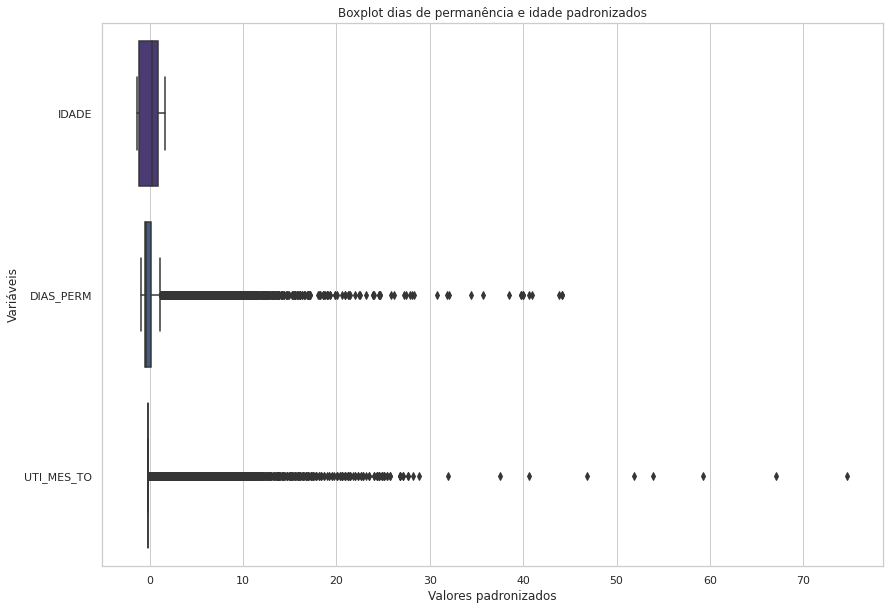

In [140]:
#GERANDO BOXPLOTS
sns.set(rc={'figure.figsize':(14, 10)})
sns.set_theme(style="whitegrid", palette="viridis")

box = sns.boxplot(y = "variables", x = "standard_value", data = sih_box2)
box.set(xlabel ="Valores padronizados", ylabel = "Variáveis", title ='Boxplot dias de permanência e idade padronizados')

In [141]:
#SELECIONANDO DADOS COM DISTRIBUIÇÃO MAIOR QUE -1.96 E MENOR QUE 1.96
sih_box = pd.DataFrame(sih_box.stack()).reset_index()
sih_box.drop('level_0', axis = 1, inplace = True)
sih_box.rename(columns = {'level_1':'variables_originals', 0:'value'}, inplace = True)

sih_box = pd.concat([sih_box.reset_index(drop=True), sih_box2.reset_index(drop=True)], axis=1)
sih_box = sih_box[(sih_box['standard_value'] >= -1.96) & (sih_box['standard_value'] <= 1.96)]

In [142]:
#SELECIONANDO VALORES MÍNIMOS E MÁXIMOS 
min_values = pd.DataFrame(sih_box.groupby('variables_originals')['value'].min())
max_values = pd.DataFrame(sih_box.groupby('variables_originals')['value'].max())

min_values, max_values

(                     value
 variables_originals       
 DIAS_PERM              0.0
 IDADE                  0.0
 UTI_MES_TO             0.0,
                      value
 variables_originals       
 DIAS_PERM             21.0
 IDADE                 99.0
 UTI_MES_TO             7.0)

In [143]:
sih_pneumo2 = sih_pneumo2[(sih_pneumo2['IDADE'] <= max_values.loc['IDADE', 'value']) 
                        & (sih_pneumo2['DIAS_PERM'] <= max_values.loc['DIAS_PERM', 'value'])
                        & (sih_pneumo2['UTI_MES_TO'] <= max_values.loc['UTI_MES_TO', 'value'])]

[Text(0.5, 0, 'Valores'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Boxplot dias de permanência')]

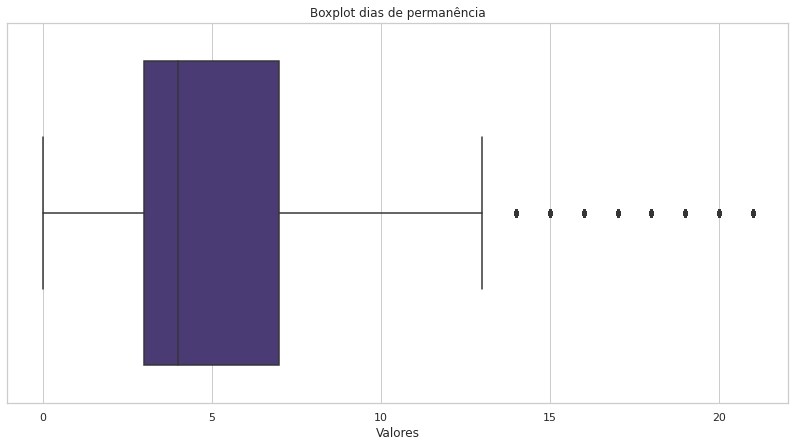

In [144]:
#GERANDO BOXPLOT DE DIAS DE PERMANÊNCIA
sns.set(rc={'figure.figsize':(14, 7)})
sns.set_theme(style="whitegrid", palette="viridis")

box1 = sns.boxplot(x = "DIAS_PERM", data = sih_pneumo2)
box1.set(xlabel ="Valores", ylabel = "", title ='Boxplot dias de permanência')


[Text(0.5, 0, 'Valores'), Text(0, 0.5, ''), Text(0.5, 1.0, 'Boxplot idade')]

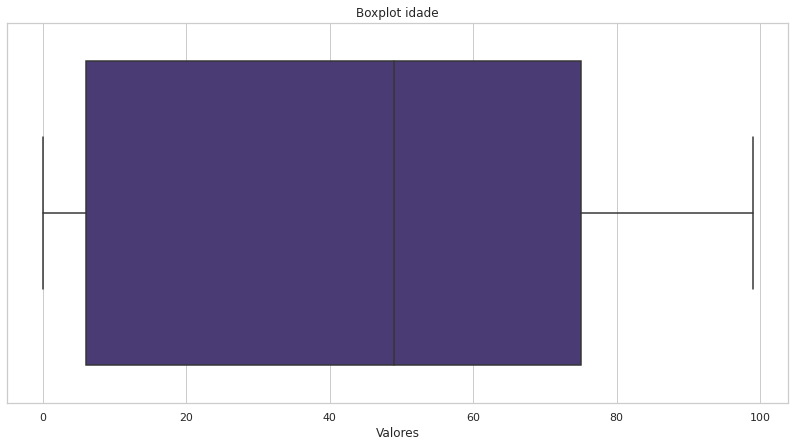

In [145]:
#GERANDO BOXPLOT DE IDADE
sns.set(rc={'figure.figsize':(14, 7)})
sns.set_theme(style="whitegrid", palette="viridis")

box2 = sns.boxplot(x = "IDADE", data = sih_pneumo2)
box2.set(xlabel ="Valores", ylabel = "", title ='Boxplot idade')

[Text(0.5, 0, 'Valores'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Boxplot dias de permanência em UTI')]

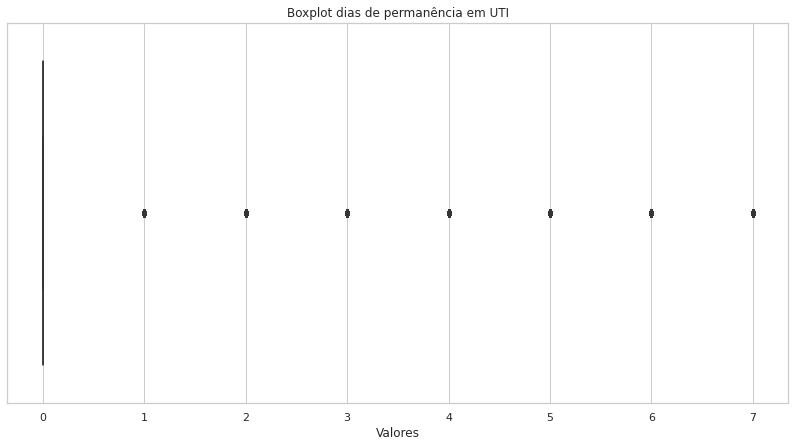

In [146]:
#GERANDO BOXPLOT DE DIAS DE PERMANÊNCIA EM UTI
sns.set(rc={'figure.figsize':(14, 7)})
sns.set_theme(style="whitegrid", palette="viridis")

box3 = sns.boxplot(x = "UTI_MES_TO", data = sih_pneumo2)
box3.set(xlabel ="Valores", ylabel = "", title ='Boxplot dias de permanência em UTI')

## 3. Análise descritiva 

#### 3.1 Frequencia - variáveis categóricas

In [147]:
#NÚMERO DE INTERNAÇÕES ANTES E DEPOIS DA PREPARAÇÃO DA BASE
len(sih_pneumo), len(sih_pneumo2), (len(sih_pneumo)-len(sih_pneumo2))

(702455, 658719, 43736)

In [148]:
#FREQUENCIA DE INTERNAÇÕES POR SEXO
dic_sexo = {1:"Masculino", 3:"Feminino"}
sih_pneumo2["SEXO"] = sih_pneumo2["SEXO"].replace(dic_sexo)

sexo = pd.DataFrame(sih_pneumo2["SEXO"].value_counts())
sexo

,SEXO
Masculino,343908
Feminino,314811


In [149]:
#TABELA DE FREQUÊNCIA POR FAIXA ETÁRIA
sih_pneumo2["FAIXA_ETARIA"] = np.where(sih_pneumo2["IDADE"] <= 10, '0 - 10',
                              np.where(sih_pneumo2["IDADE"] < 20, '11-19',
                              np.where(sih_pneumo2["IDADE"] <= 60, '20-59', 
                              np.where(sih_pneumo2["IDADE"] <= 100, '60+',
                              'não informado'))))

In [150]:
#MORTALIDADE POR FAIXA ETÁRIA
mortalidade_por_fe = pd.DataFrame(pd.crosstab(sih_pneumo2["FAIXA_ETARIA"], sih_pneumo2["MORTE"], margins=True))
mortalidade_por_fe

MORTE,0,1,All
FAIXA_ETARIA,,,
0 - 10,219309,1855,221164
11-19,25900,402,26302
20-59,126782,9870,136652
60+,224330,50271,274601
All,596321,62398,658719


In [151]:
#PIRAMIDE ETÁRIA DAS INTERNAÇÕES
sexo_idade = pd.DataFrame(sih_pneumo2[["SEXO", "FAIXA_ETARIA"]])
sexo_idade["FREQUENCIA"] = 1
sexo_idade = pd.DataFrame(sexo_idade.groupby(["SEXO", "FAIXA_ETARIA"])["FREQUENCIA"].sum())
sexo_idade.reset_index(inplace=True)
sexo_idade = sexo_idade.pivot_table(index=["FAIXA_ETARIA"], 
                                    columns='SEXO', 
                                    values='FREQUENCIA')
sexo_idade.reset_index(inplace=True)
sexo_idade.index.names = ['index']

y_age = sexo_idade["FAIXA_ETARIA"]
x_F = sexo_idade["Feminino"]*-1
x_M = sexo_idade["Masculino"]

fig = gp.Figure()
fig.add_trace(gp.Bar(y= y_age, x = x_M, 
                     name = 'Masculino', 
                     orientation = 'h',
                     marker_color='#21918c'))
fig.add_trace(gp.Bar(y = y_age, x = x_F,
                     name = 'Feminino', 
                     orientation = 'h',
                     marker_color='#440154'))
fig.update_layout(title = 'Número de internações por sexo e faixa etária, Brasil, 2017-2021',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(                                
                              title = 'Frequência',
                              title_font_size = 14)
                 ) 
fig.show()

In [152]:
#NÚMERO DE MORTES REGISTRADAS POR ANO
mortes_por_ano = pd.DataFrame(pd.crosstab(sih_pneumo2['MORTE'], sih_pneumo2['ANO_INT'], margins=True))
mortes_por_ano

ANO_INT,2017,2018,2019,2020,2021,All
MORTE,,,,,,
0,139205,147447,153599,79974,76096,596321
1,12014,13471,15228,11544,10141,62398
All,151219,160918,168827,91518,86237,658719


In [153]:
#CID PRINCIPAL POR ANO
cid_por_ano = pd.DataFrame(pd.crosstab(sih_pneumo2['DIAG_PRINC'], sih_pneumo2['ANO_INT'], margins=True))
cid_por_ano

ANO_INT,2017,2018,2019,2020,2021,All
DIAG_PRINC,,,,,,
J13 - Pneumonia Pneumocócica,2573,2702,2374,1008,690,9347
J14 - Pneumonia por Haemophilus infuenzae,422,183,165,105,132,1007
J153 - Pneumonia por Streptococus,409,471,301,144,112,1437
J154 - Pneumonia por Streptococus,1377,1272,1151,491,398,4689
J158 - Pneumonia bacteriana NE,55534,55849,55573,29364,28586,224906
J159 - Pneumonia bacteriana NE,85583,95533,104856,57946,53480,397398
J181 - Pneumonia lobar NE,5321,4908,4407,2460,2839,19935
All,151219,160918,168827,91518,86237,658719


In [154]:
#MORTALIDADE POR CID
mortes_por_cid = pd.DataFrame(pd.crosstab(sih_pneumo2['MORTE'], sih_pneumo2['DIAG_PRINC'], margins=True))
mortes_por_cid

DIAG_PRINC,J13 - Pneumonia Pneumocócica,J14 - Pneumonia por Haemophilus infuenzae,J153 - Pneumonia por Streptococus,J154 - Pneumonia por Streptococus,J158 - Pneumonia bacteriana NE,J159 - Pneumonia bacteriana NE,J181 - Pneumonia lobar NE,All
MORTE,,,,,,,,
0,8480,956,1217,4362,206761,356624,17921,596321
1,867,51,220,327,18145,40774,2014,62398
All,9347,1007,1437,4689,224906,397398,19935,658719


#### 3.2 Medidas resumo - variáveis numéricas

[Text(0.5, 0, 'Valores'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Histograma de idade por internação, Brasil, 2017 - 2021')]

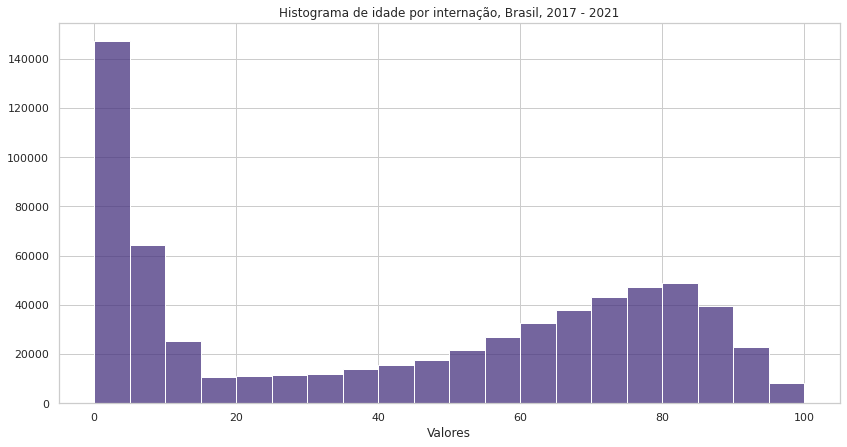

In [155]:
#CRIANDO HISTOGRAMA DE IDADE
sns.set(rc={'figure.figsize':(14, 7)})
sns.set_theme(style="whitegrid", palette="viridis")

hist1 = sns.histplot(x = "IDADE", data = sih_pneumo2, binwidth=5)
hist1.set(xlabel ="Valores", ylabel = "", title ='Histograma de idade por internação, Brasil, 2017 - 2021')

In [156]:
#MEDIDAS RESUMO PARA A IDADE
idade_resumo = pd.DataFrame(sih_pneumo2.agg({"IDADE":["mean", "std", "median", "min", "max"]}).round(1))
idade_resumo.loc["iqr_25", 'IDADE'] = sih_pneumo2["IDADE"].quantile(0.25)
idade_resumo.loc["iqr_75", 'IDADE'] = sih_pneumo2["IDADE"].quantile(0.75)
idade_resumo

,IDADE
mean,43.2
std,33.4
median,49.0
min,0.0
max,99.0
iqr_25,6.0
iqr_75,75.0


[Text(0.5, 0, 'Valores'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Histograma dias de permanencia por internação, Brasil, 2017 - 2021')]

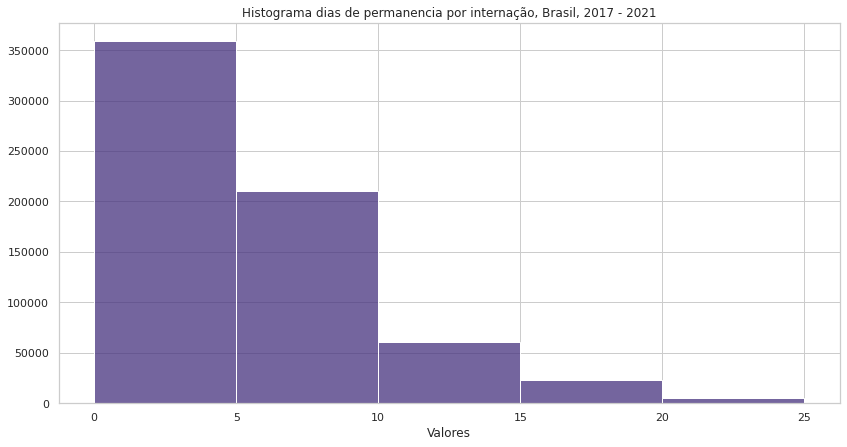

In [157]:
#CRIANDO HISTOGRAMA DE DIAS DE PERMANÊNCIA
sns.set(rc={'figure.figsize':(14, 7)})
sns.set_theme(style="whitegrid", palette="viridis")

hist1 = sns.histplot(x = "DIAS_PERM", data = sih_pneumo2, binwidth=5)
hist1.set(xlabel ="Valores", ylabel = "", title ='Histograma dias de permanencia por internação, Brasil, 2017 - 2021')

In [158]:
#MEDIDAS RESUMO PARA A DIAS DE PERMANENCIA 
diasperm_resumo = pd.DataFrame(sih_pneumo2.agg({"DIAS_PERM":["mean", "std", "median", "min", "max"]}).round(1))
diasperm_resumo.loc["iqr_25", 'DIAS_PERM'] = sih_pneumo2["DIAS_PERM"].quantile(0.25)
diasperm_resumo.loc["iqr_75", 'DIAS_PERM'] = sih_pneumo2["DIAS_PERM"].quantile(0.75)
diasperm_resumo

,DIAS_PERM
mean,5.4
std,4.0
median,4.0
min,0.0
max,21.0
iqr_25,3.0
iqr_75,7.0


[Text(0.5, 0, 'Valores'),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Histograma dias de permanencia na UTI por internação, Brasil, 2017 - 2021')]

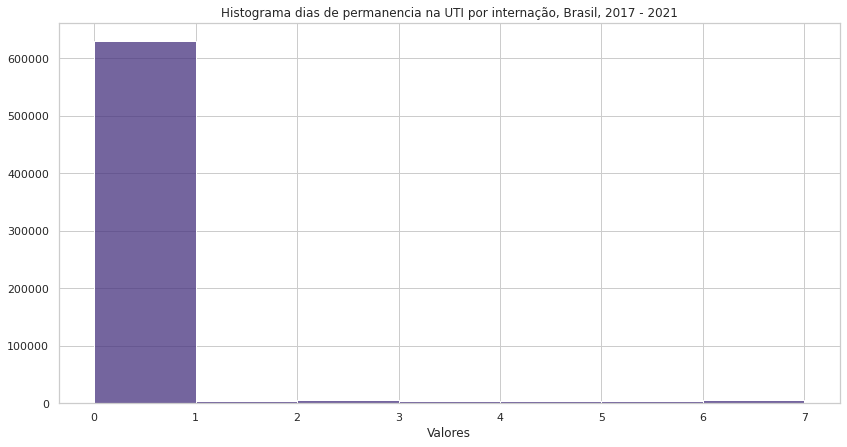

In [159]:
#CRIANDO HISTOGRAMA DE DIAS DE PERMANÊNCIA NA UTI
sns.set(rc={'figure.figsize':(14, 7)})
sns.set_theme(style="whitegrid", palette="viridis")

hist1 = sns.histplot(x = "UTI_MES_TO", data = sih_pneumo2, binwidth=1)
hist1.set(xlabel ="Valores", ylabel = "", title ='Histograma dias de permanencia na UTI por internação, Brasil, 2017 - 2021')

In [160]:
#MEDIDAS RESUMO PARA A DIAS DE PERMANENCIA NA UTI
diasperm_resumo = pd.DataFrame(sih_pneumo2.agg({"UTI_MES_TO":["mean", "std", "median", "min", "max"]}).round(1))
diasperm_resumo.loc["iqr_25", 'UTI_MES_TO'] = sih_pneumo2["DIAS_PERM"].quantile(0.25)
diasperm_resumo.loc["iqr_75", 'UTI_MES_TO'] = sih_pneumo2["UTI_MES_TO"].quantile(0.75)
diasperm_resumo

,UTI_MES_TO
mean,0.2
std,0.8
median,0.0
min,0.0
max,7.0
iqr_25,3.0
iqr_75,0.0


#### 3.3 Calculando taxas

In [161]:
#LETALIDADE POR CID
mortalidade_por_cid = pd.DataFrame((mortes_por_cid.loc[1,]/cid_por_ano["All"]*100).round(2))
mortalidade_por_cid.reset_index(inplace= True)
mortalidade_por_cid.rename(columns= {0: "LETALIDADE"}, inplace= True)
mortalidade_por_cid

,DIAG_PRINC,LETALIDADE
0,J13 - Pneumonia Pneumocócica,9.28
1,J14 - Pneumonia por Haemophilus infuenzae,5.06
2,J153 - Pneumonia por Streptococus,15.31
3,J154 - Pneumonia por Streptococus,6.97
4,J158 - Pneumonia bacteriana NE,8.07
5,J159 - Pneumonia bacteriana NE,10.26
6,J181 - Pneumonia lobar NE,10.10
7,All,9.47


[Text(0.5, 0, 'Taxa de letalidade por internação'),
 Text(0, 0.5, 'Diagnóstico principal'),
 Text(0.5, 1.0, 'Letalidade por internações por cid específica por pneumonia sensível à APS, Brasil, 2017 a 2021')]

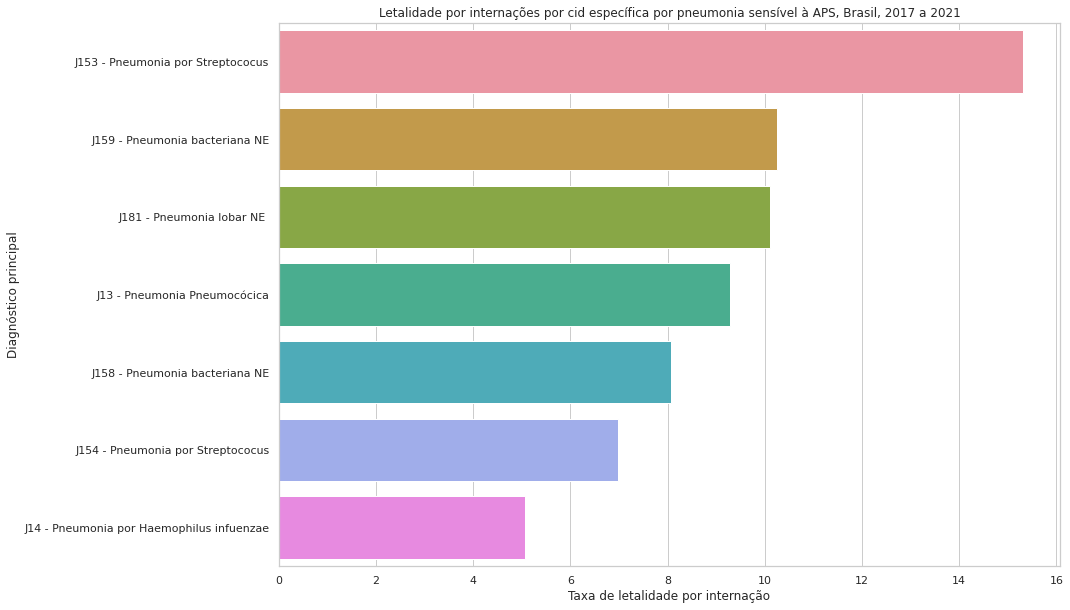

In [162]:
#GRÁFICO DE BARRAS POR CID
mortalidade_por_cid2 = mortalidade_por_cid.loc[0:6,]

order = mortalidade_por_cid2.groupby('DIAG_PRINC')['LETALIDADE'].sum().sort_values(ascending=False).index.values

sns.set(rc={'figure.figsize':(14, 10)})
sns.set_theme(style="whitegrid", palette="viridis")

bar = sns.barplot(x = "LETALIDADE", y = "DIAG_PRINC", data = mortalidade_por_cid2, order = order)
bar.set(xlabel ="Taxa de letalidade por internação", ylabel = "Diagnóstico principal", title ='Letalidade por internações por cid específica por pneumonia sensível à APS, Brasil, 2017 a 2021')

In [163]:
#LETALIDADE POR INTERNAÇÕES
letal_por_ano = pd.DataFrame((mortes_por_ano.loc[1,]/cid_por_ano.loc["All",]*100).round(2))
letal_por_ano.reset_index(inplace= True)
letal_por_ano.rename(columns= {0: "LETALIDADE"}, inplace= True)
letal_por_ano

,ANO_INT,LETALIDADE
0,2017,7.94
1,2018,8.37
2,2019,9.02
3,2020,12.61
4,2021,11.76
5,All,9.47


/tmp/ipykernel_2050/1556816475.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[[<matplotlib.axis.XTick at 0x7f1f391118e0>,

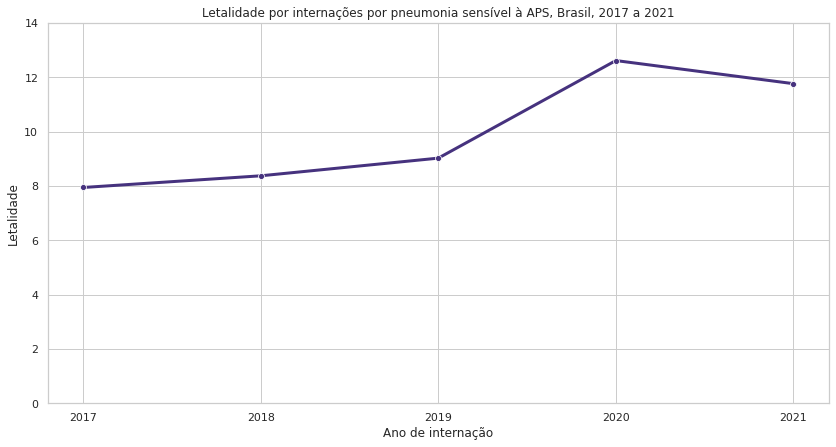

In [164]:
#GRÁFICO DE LETALIDADE POR ANO
letal_por_ano2 = letal_por_ano.loc[0:4,]
letal_por_ano2["ANO_INT"] = letal_por_ano2["ANO_INT"].astype("int64")

sns.set(rc={'figure.figsize':(14, 7)})
sns.set_theme(style="whitegrid", palette="viridis")

line = sns.lineplot(x = "ANO_INT", y = "LETALIDADE", linewidth = 3, marker='o', data = letal_por_ano2)
line.set(xlabel ="Ano de internação", ylabel = "Letalidade", title ='Letalidade por internações por pneumonia sensível à APS, Brasil, 2017 a 2021')
line.set(xticks=np.arange(2017,2022,1), yticks=np.arange(0,16,2))

In [165]:
#LETALIDADE PADRONIZADA POR FAIXA ETÁRIA
letal_por_fe = pd.DataFrame((mortalidade_por_fe[1]/mortalidade_por_fe['All']*100).round(2))
letal_por_fe.reset_index(inplace = True)
letal_por_fe.set_axis(["FAIXA_ETARIA", "LETALIDADE"], axis = 1, inplace = True)
letal_por_fe


,FAIXA_ETARIA,LETALIDADE
0,0 - 10,0.84
1,11-19,1.53
2,20-59,7.22
3,60+,18.31
4,All,9.47


[Text(0.5, 0, 'Taxa de letalidade por faixa etária'),
 Text(0, 0.5, 'Faixa etária'),
 Text(0.5, 1.0, 'Letalidade por internações por faixa etária por pneumonia sensível à APS, Brasil, 2017 a 2021')]

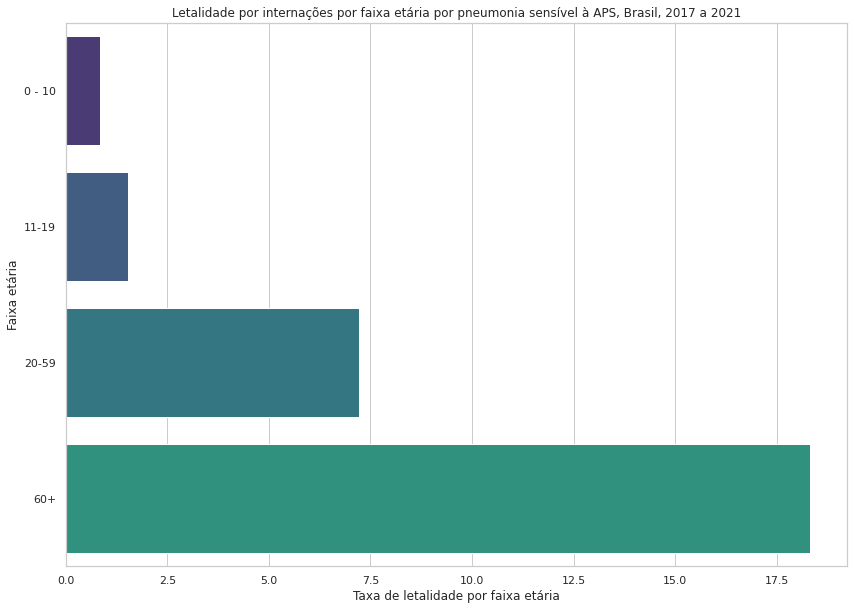

In [166]:
#GRÁFICO DE BARRAS DE LETALIDADE POR FAIXA DE IDADE
letal_por_fe = letal_por_fe.loc[0:3,]

sns.set(rc={'figure.figsize':(14, 10)})
sns.set_theme(style="whitegrid", palette="viridis")

bar2 = sns.barplot(x = "LETALIDADE", y = "FAIXA_ETARIA", data = letal_por_fe)
bar2.set(xlabel ="Taxa de letalidade por faixa etária", ylabel = "Faixa etária", title ='Letalidade por internações por faixa etária por pneumonia sensível à APS, Brasil, 2017 a 2021')

In [167]:
#TRATANDO DADOS DE REGIÃO DOS CASOS DE PNEUMONIA PARA CALCULAR TAXAS DE INTERNAÇÃO
sih_pneumo2["REGIAO"] = sih_pneumo2["UF"].str.slice(0,1)
sih_pneumo2["REGIAO"] = sih_pneumo2["REGIAO"].replace(regiao)

In [168]:
#TAXA DE INTERNAÇÃO POR ANO E REGIÃO
sih_pneumo3 = pd.DataFrame(sih_pneumo2.groupby(['REGIAO', 'ANO_INT'])['ANO_INT'].count())
sih_pneumo3.rename(columns= {'ANO_INT':'CASOS_PNEUMONIA'}, inplace= True)
sih_pneumo3.reset_index(inplace = True)
sih_pneumo3['ANO_INT'] = sih_pneumo3['ANO_INT'].astype(str)
sih_pneumo3.set_index(['REGIAO', 'ANO_INT'], inplace= True)

internacoes_br2 = internacoes_br.drop("UF", axis=1)
internacoes_br2 = pd.melt(internacoes_br2, id_vars=["REGIAO"])
internacoes_br2.rename(columns= {'variable':'ANO_INT', 'value':'INTERNACOES'}, inplace= True)
internacoes_br2.set_index(['REGIAO', 'ANO_INT'], inplace= True)

taxa_uf_ano = internacoes_br2.merge(sih_pneumo3, right_index = True, left_index= True)
taxa_uf_ano.reset_index(inplace = True)
taxa_uf_ano['TAXA_INTERNACAO'] = (taxa_uf_ano['CASOS_PNEUMONIA']/taxa_uf_ano['INTERNACOES']*1000).round(2)

taxa_uf_ano1 = taxa_uf_ano[['REGIAO', 'ANO_INT', 'TAXA_INTERNACAO']].copy()
taxa_uf_ano1 = pd.pivot_table(taxa_uf_ano1, index = 'ANO_INT', columns='REGIAO', values= 'TAXA_INTERNACAO')
taxa_uf_ano1.reset_index(inplace= True)
taxa_uf_ano1.rename(columns={"Centro-Oeste":"Centro_Oeste"}, inplace= True)
taxa_uf_ano1["ANO_INT"] = taxa_uf_ano1["ANO_INT"].astype("int64")
taxa_uf_ano1

REGIAO,ANO_INT,Centro_Oeste,Nordeste,Norte,Sudeste,Sul
0,2017,74.6675,176.973333,232.137143,96.4275,40.086667
1,2018,76.0475,192.023333,225.270000,100.3475,40.340000
2,2019,84.2250,195.101111,222.355714,101.4100,40.020000
3,2020,46.3700,107.280000,140.718571,71.8050,23.303333
4,2021,33.8400,90.272222,152.111429,56.6025,20.143333


In [169]:
#SALVANDO DADOS EM LISTAS
x = taxa_uf_ano1['ANO_INT']
y1 = taxa_uf_ano1['Centro_Oeste']
y2 = taxa_uf_ano1['Nordeste']
y3 = taxa_uf_ano1['Norte']
y4 = taxa_uf_ano1['Sudeste']
y5 = taxa_uf_ano1['Sul']

Text(0, 0.5, 'Taxa de internação')

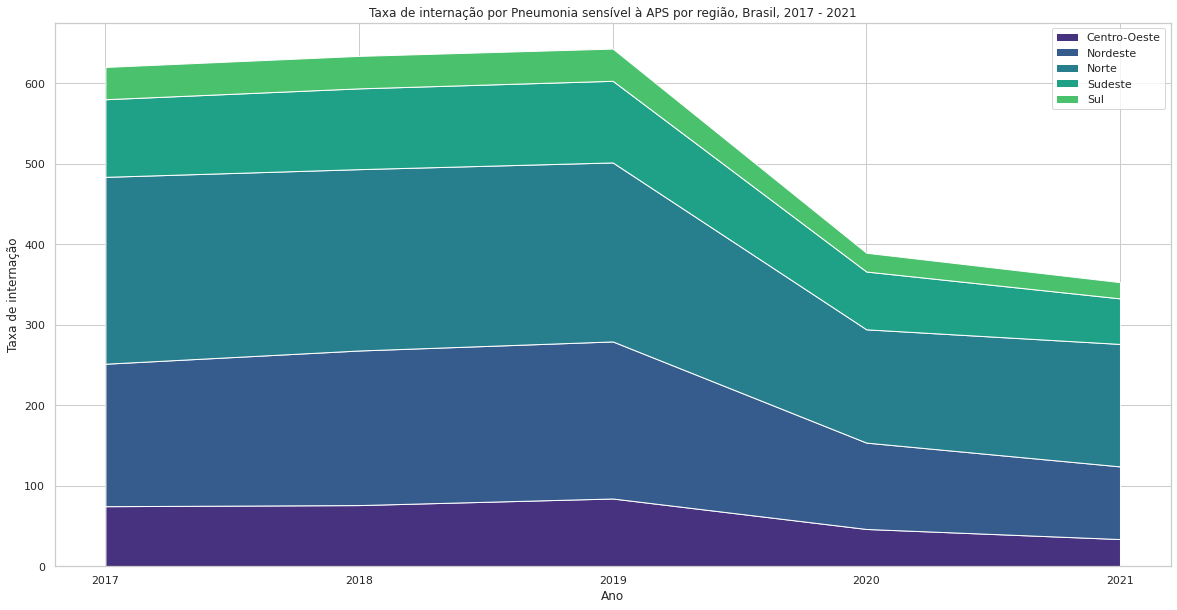

In [170]:
#GRÁFICO DE ÁREA DE TAXA DE INTERNAÇÃO POR ANO 
sns.set(rc={'figure.figsize':(20, 10)})
sns.set_theme(style="whitegrid", palette="viridis")

plt.stackplot(x, y1, y2, y3, y4, y5, labels=['Centro-Oeste','Nordeste','Norte', 'Sudeste', 'Sul'])
plt.xticks(x, x, rotation ='horizontal')
plt.legend(loc='upper right')
plt.title("Taxa de internação por Pneumonia sensível à APS por região, Brasil, 2017 - 2021")
plt.xlabel("Ano")
plt.ylabel("Taxa de internação")

#### 3.4 Análise de correlação e associação das variáveis

In [171]:
sih_pneumo2.head()

,N_AIH,IDADE,SEXO,MORTE,DIAS_PERM,DIAG_PRINC,DT_INTER,ANO_CMPT,MES_CMPT,MARCA_UTI,UTI_MES_TO,ANO_INT,UF,FAIXA_ETARIA,REGIAO
0,1217100049066,74.0,Masculino,1,8,J159 - Pneumonia bacteriana NE,2017-01-23,2017,1,Não usou UTI,0,2017,12,60+,Norte
3,1217100051343,63.0,Masculino,0,1,J159 - Pneumonia bacteriana NE,2017-01-11,2017,1,Não usou UTI,0,2017,12,60+,Norte
5,1216100558520,74.0,Feminino,0,8,J159 - Pneumonia bacteriana NE,2017-01-17,2017,1,Não usou UTI,0,2017,12,60+,Norte
6,1216100558937,32.0,Feminino,1,7,J159 - Pneumonia bacteriana NE,2017-01-20,2017,1,Não usou UTI,0,2017,12,20-59,Norte
7,1217100046118,1.0,Feminino,0,5,J158 - Pneumonia bacteriana NE,2017-01-08,2017,1,Não usou UTI,0,2017,12,0 - 10,Norte


In [172]:
#TRANSFORMANDO DADOS PARA A ANÁLISE
sih_fn = sih_pneumo2.copy()
sih_fn.drop(['DT_INTER', 'ANO_CMPT', 'MES_CMPT', 'ANO_INT', 'UF', 'FAIXA_ETARIA'], axis = 1, inplace= True)
sih_fn.set_index("N_AIH", inplace = True)
sih_fn['SEXO'] = np.where(sih_fn['SEXO'] == 'Masculino', 1, 0)
sih_fn['DIAG_PRINC'] = np.where(sih_fn['DIAG_PRINC'] == 'J159 - Pneumonia bacteriana NE', 1, 0)
sih_fn['MARCA_UTI'] = np.where(sih_fn['MARCA_UTI'] == 'Não usou UTI', 0, 1)
sih_fn['REGIAO'] = np.where(sih_fn['REGIAO'] == 'Sudeste', 1, 0)
sih_fn['REGIAO'] = np.where(sih_fn['REGIAO'] == 'Sudeste', 1, 0)

sih_fn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658719 entries, 1217100049066 to 1721101761060
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDADE       658719 non-null  float64
 1   SEXO        658719 non-null  int64  
 2   MORTE       658719 non-null  int64  
 3   DIAS_PERM   658719 non-null  int64  
 4   DIAG_PRINC  658719 non-null  int64  
 5   MARCA_UTI   658719 non-null  int64  
 6   UTI_MES_TO  658719 non-null  int64  
 7   REGIAO      658719 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 45.2 MB


In [173]:
#SALVANDO DATA.FRAME FINAL PARA O MODELO
sih_fn = pd.read_csv("sih_pneumonia_1721_trat.csv")

##### 3.4.1 Correlação de variáveis numéricas

In [174]:
#CORRELAÇÃO ENTRE IDADE E DIAS DE PERMANENCIA
corr_idade_perm = pearsonr(sih_fn['IDADE'], sih_fn['DIAS_PERM'])
corr_idade_perm

PearsonRResult(statistic=0.12088475909432952, pvalue=0.0)

In [178]:
#CORRELAÇÃO ENTRE IDADE E DIAS DE PERMANENCIA
corr_idade_uti = pearsonr(sih_fn['IDADE'], sih_fn['UTI_MES_TO'])
corr_idade_uti

PearsonRResult(statistic=0.0415492485143513, pvalue=1.6866608274755888e-249)

##### 3.4.2 Associação entre as variáveis

In [190]:
#ASSOCIAÇÃO ENTRE MORTE E SEXO
sexo2 = pd.crosstab(sih_pneumo2['SEXO'], sih_pneumo2['MORTE'])

stat, p, dof, expected = chi2_contingency(sexo2)

prob = 0.95

critical = chi2.ppf(prob, dof)

if abs(stat) >= critical:
	print('Rejeitar H0')
else:
	print('Não se pode rejeitar H0')

alpha = 1.0 - prob

print('significancia=%.3f, p=%.3f' % (alpha, p))

if p <= alpha:
	print('Rejeitar H0')
else:
	print('Não se pode rejeitar H0')

Não se pode rejeitar H0
significancia=0.050, p=0.383
Não se pode rejeitar H0


In [192]:
sih_pneumo2

,N_AIH,IDADE,SEXO,MORTE,DIAS_PERM,DIAG_PRINC,DT_INTER,ANO_CMPT,MES_CMPT,MARCA_UTI,UTI_MES_TO,ANO_INT,UF,FAIXA_ETARIA,REGIAO
0,1217100049066,74.0,Masculino,1,8,J159 - Pneumonia bacteriana NE,2017-01-23,2017,1,Não usou UTI,0,2017,12,60+,Norte
3,1217100051343,63.0,Masculino,0,1,J159 - Pneumonia bacteriana NE,2017-01-11,2017,1,Não usou UTI,0,2017,12,60+,Norte
5,1216100558520,74.0,Feminino,0,8,J159 - Pneumonia bacteriana NE,2017-01-17,2017,1,Não usou UTI,0,2017,12,60+,Norte
6,1216100558937,32.0,Feminino,1,7,J159 - Pneumonia bacteriana NE,2017-01-20,2017,1,Não usou UTI,0,2017,12,20-59,Norte
7,1217100046118,1.0,Feminino,0,5,J158 - Pneumonia bacteriana NE,2017-01-08,2017,1,Não usou UTI,0,2017,12,0 - 10,Norte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734144,1721101839105,75.0,Masculino,0,18,J158 - Pneumonia bacteriana NE,2021-12-13,2022,3,Não usou UTI,0,2021,17,60+,Norte
734148,1721101788659,66.0,Feminino,0,13,J159 - Pneumonia bacteriana NE,2021-11-22,2022,3,Não usou UTI,0,2021,17,60+,Norte
734150,1721101839644,81.0,Masculino,0,9,J154 - Pneumonia por Streptococus,2021-12-22,2022,3,Não usou UTI,0,2021,17,60+,Norte
734154,1721101761038,3.0,Feminino,0,2,J159 - Pneumonia bacteriana NE,2021-12-03,2022,3,Não usou UTI,0,2021,17,0 - 10,Norte


In [193]:
#ASSOCIAÇÃO ENTRE MORTE E DIAGNÓSTICO PRINCIPAL
diag = pd.crosstab(sih_fn['DIAG_PRINC'], sih_fn['MORTE'])

stat, p, dof, expected = chi2_contingency(diag)

prob = 0.95

critical = chi2.ppf(prob, dof)

if abs(stat) >= critical:
	print('Rejeitar H0')
else:
	print('Não se pode rejeitar H0')

alpha = 1.0 - prob

print('significancia=%.3f, p=%.3f' % (alpha, p))

if p <= alpha:
	print('Rejeitar H0')
else:
	print('Não se pode rejeitar H0')

Rejeitar H0
significancia=0.050, p=0.000
Rejeitar H0


In [196]:
#ASSOCIAÇÃO ENTRE MORTE E UTI
uti2 = pd.crosstab(sih_fn['MORTE'], sih_fn['MARCA_UTI'])

stat, p, dof, expected = chi2_contingency(uti2)

prob = 0.95

critical = chi2.ppf(prob, dof)

if abs(stat) >= critical:
	print('Rejeitar H0')
else:
	print('Não se pode rejeitar H0')

alpha = 1.0 - prob

print('significancia=%.3f, p=%.3f' % (alpha, p))

if p <= alpha:
	print('Rejeitar H0')
else:
	print('Não se pode rejeitar H0')

Rejeitar H0
significancia=0.050, p=0.000
Rejeitar H0


In [197]:
#ASSOCIAÇÃO ENTRE MORTE E REGIÃO
regiao2 = pd.crosstab(sih_fn['MORTE'], sih_fn['MARCA_UTI'])

stat, p, dof, expected = chi2_contingency(regiao2)

prob = 0.95

critical = chi2.ppf(prob, dof)

if abs(stat) >= critical:
	print('Rejeitar H0')
else:
	print('Não se pode rejeitar H0')

alpha = 1.0 - prob

print('significancia=%.3f, p=%.3f' % (alpha, p))

if p <= alpha:
	print('Rejeitar H0')
else:
	print('Não se pode rejeitar H0')

Rejeitar H0
significancia=0.050, p=0.000
Rejeitar H0
